#Time series prediction using Transformer#

##Downloading data##

In [1]:
!gdown --id 1GZxDATmFkkXhX2mjBq0q5OKoT5dT22Rc -O dataset.csv # https://drive.google.com/file/d/1y5skDqS7T40IMEQtskm2VSVTloKdmzij/view?usp=sharing https://drive.google.com/file/d/1aSoXnzJhs9XMQgmG-i-hscO7cte7-_Ol/view?usp=sharing my_path = "/content/drive/MyDrive/ProjDL/whole_set.nc"

Downloading...
From: https://drive.google.com/uc?id=1GZxDATmFkkXhX2mjBq0q5OKoT5dT22Rc
To: /content/dataset.csv
100% 497k/497k [00:00<00:00, 72.8MB/s]


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from IPython import display
import numpy as np
import random
import matplotlib.pyplot as plt
params = {'text.usetex' : False,

          'font.size' : 16,
          }
plt.rcParams.update(params)
import matplotlib.dates as mdates

import torchvision
from torchvision import transforms

from time import time
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from pandas_datareader import data as pdr

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import os
import math

In [3]:
df = pd.read_csv('/content/dataset.csv')
df = df.set_index(['time'])

In [4]:
device = 'cuda'
assert torch.cuda.is_available()

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

##Transformer##

Required blocks, functions, etc.

In [5]:
def a_norm(Q, K):
    m = torch.matmul(Q, K.transpose(2,1).float())
    m /= torch.sqrt(torch.tensor(Q.shape[-1]).float())    
    return torch.softmax(m , -1)

def attention(Q, K, V):
    a = a_norm(Q, K)
    return  torch.matmul(a,  V)

class Value(torch.nn.Module):
    def __init__(self, dim_input, dim_val):
        super(Value, self).__init__()
        self.dim_val = dim_val
        
        self.fc1 = nn.Linear(dim_input, dim_val, bias = False)
        
    def forward(self, x):
        x = self.fc1(x)
        
        return x

class Query(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Query, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        
    def forward(self, x):
        
        x = self.fc1(x)
        
        return x

class Key(torch.nn.Module):
    def __init__(self, dim_input, dim_attn):
        super(Key, self).__init__()
        self.dim_attn = dim_attn
        
        self.fc1 = nn.Linear(dim_input, dim_attn, bias = False)
        
    def forward(self, x):
        x = self.fc1(x)
        
        return x

In [6]:
class AttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn):
        super(AttentionBlock, self).__init__()
        self.value = Value(dim_val, dim_val)
        self.key = Key(dim_val, dim_attn)
        self.query = Query(dim_val, dim_attn)
    
    def forward(self, x, kv = None):
        if(kv is None):
            #Attention with x connected to Q,K and V (For encoder)
            return attention(self.query(x), self.key(x), self.value(x))
        
        #Attention with x as Q, external vector kv as K an V (For decoder)
        return attention(self.query(x), self.key(kv), self.value(kv))
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads):
        super(MultiHeadAttentionBlock, self).__init__()
        self.heads = []
        for i in range(n_heads):
            self.heads.append(AttentionBlock(dim_val, dim_attn))
        
        self.heads = nn.ModuleList(self.heads)
        self.fc = nn.Linear(n_heads * dim_val, dim_val, bias = False)
                      
    def forward(self, x, kv = None):
        a = []
        for h in self.heads:
            a.append(h(x, kv = kv))
            
        a = torch.stack(a, dim = -1) #combine heads
        a = a.flatten(start_dim = 2) #flatten all head outputs
        
        x = self.fc(a)
        
        return x

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html  
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]. squeeze(1)
        return x     


In [7]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionBlock(dim_val, dim_attn , n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
    
    def forward(self, x):
        a = self.attn(x)
        x = self.norm1(x + a)
        
        a = self.fc1(F.relu(self.fc2(x)))
        x = self.norm2(x + a)
        
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, n_heads = 1):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.attn2 = MultiHeadAttentionBlock(dim_val, dim_attn, n_heads)
        self.fc1 = nn.Linear(dim_val, dim_val)
        self.fc2 = nn.Linear(dim_val, dim_val)
        
        self.norm1 = nn.LayerNorm(dim_val)
        self.norm2 = nn.LayerNorm(dim_val)
        self.norm3 = nn.LayerNorm(dim_val)
        
    def forward(self, x, enc):
        a = self.attn1(x)
        x = self.norm1(a + x)
        
        a = self.attn2(x, kv = enc)
        x = self.norm2(a + x)
        
        a = self.fc1(F.relu(self.fc2(x)))
        
        x = self.norm3(x + a)
        return x

  
'''FFT related repo https://github.com/jaketae/fnet'''

def fourier_transform(x):
    return torch.fft.fft2(x, dim=(-1, -2)).real

class FeedForward(nn.Module):
    def __init__(self, num_features, expansion_factor, dropout):
        super().__init__()
        num_hidden = expansion_factor * num_features
        self.fc1 = nn.Linear(num_features, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_features)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout1(F.gelu(self.fc1(x)))
        out = self.dropout2(self.fc2(x))
        return out

class FNetEncoderLayer(nn.Module):
    def __init__(self, d_model, expansion_factor, dropout):
        super().__init__()
        self.ff = FeedForward(d_model, expansion_factor, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = fourier_transform(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.ff(x)
        out = self.norm2(x + residual)
        return out

In [8]:
class Transformer(torch.nn.Module):
    def __init__(self, dim_val, dim_attn, input_size, dec_seq_len, out_seq_len, n_decoder_layers = 1, n_encoder_layers = 1, n_heads = 1, expansion_factor=2, dropout=0.5, fourier = False):
        super(Transformer, self).__init__()
        self.dec_seq_len = dec_seq_len
        
        #Initiate encoder and Decoder layers
        self.encs = []
        for i in range(n_encoder_layers):
            if fourier == True:
              self.encs.append(FNetEncoderLayer(dim_val, expansion_factor, dropout))
            else:
              self.encs.append(EncoderLayer(dim_val, dim_attn, n_heads))

        self.decs = []
        for i in range(n_decoder_layers):
            self.decs.append(DecoderLayer(dim_val, dim_attn, n_heads))
        
        self.pos = PositionalEncoding(dim_val)
        
        
        
        self.decs = nn.ModuleList(self.decs)
        self.encs = nn.ModuleList(self.encs)
        
        #Dense layers for managing network inputs and outputs
        self.enc_input_fc = nn.Linear(input_size, dim_val)
        self.dec_input_fc = nn.Linear(input_size, dim_val)
        self.out_fc = nn.Linear(dec_seq_len * dim_val, out_seq_len)

    
    def forward(self, x):
        #encoder
        embed_enc_x = self.pos(self.enc_input_fc(x))
        e = self.encs[0](embed_enc_x)
        for enc in self.encs[1:]:
            e = enc(e)
        
        #decoder
        embed_dec_x = self.dec_input_fc(x[:,-self.dec_seq_len:])
        d = self.decs[0](embed_dec_x, e)
        for dec in self.decs[1:]:
            d = dec(d, e)
            
        #output
        x = self.out_fc(d.flatten(start_dim=1))
        
        return x

In [9]:
data = df

In [10]:
data.isna().any()[lambda x:x]

Series([], dtype: bool)

In [11]:
data

,TempOut,WindSpeed,WindRun,SolarRad,SolarEnergy,HeatD-D,CoolD-D,OutHum,P_GEN
time,,,,,,,,,
2014-06-10 02:30:00,15.7,0,0.0,0,0.0,0.056,0.0,89,-0.005
2014-06-10 03:00:00,15.2,0,0.0,0,0.0,0.065,0.0,90,-0.005
2014-06-10 03:30:00,14.9,0,0.0,0,0.0,0.072,0.0,90,-0.005
2014-06-10 04:00:00,14.4,0,0.0,0,0.0,0.081,0.0,89,-0.005
2014-06-10 04:30:00,14.2,0,0.0,0,0.0,0.087,0.0,90,-0.003
...,...,...,...,...,...,...,...,...,...
2014-11-19 16:00:00,8.0,0,0.0,0,0.0,0.215,0.0,88,-0.005
2014-11-19 16:30:00,8.1,0,0.0,0,0.0,0.214,0.0,90,-0.005
2014-11-19 17:00:00,8.0,0,0.0,0,0.0,0.215,0.0,90,-0.005


##Time series setup, dataloader and normalizing the data 

In [12]:
n_timesteps, n_assets  = data.shape
window = 10
 

def indices(n_timesteps, test_part, val_part):
  
    split_ix_tr = int(n_timesteps * test_part)
    split_ix_val = int(n_timesteps * val_part)
    indices_train = list(range(split_ix_tr))
    indices_val = list(range(split_ix_tr, split_ix_val + split_ix_tr))
    indices_test = list(range(split_ix_val + split_ix_tr, n_timesteps))

    return indices_train, indices_val, indices_test

indices_train, indices_val, indices_test = indices(n_timesteps, 0.7, 0.15)

In [13]:
len(indices_train) + len(indices_val) + len(indices_test) == data.shape[0]

True

In [14]:
scaler_y = StandardScaler()
y = data['P_GEN'].values
y=y.reshape(-1, 1)
scaler_y.fit(y[indices_train[0]:indices_train[-1]])
y = scaler_y.transform(y)

data = data.drop(columns = 'P_GEN')
scaler_X = StandardScaler()
X = data.values
scaler_X.fit(X[indices_train[0]:indices_train[-1]])
X = scaler_X.transform(X)



In [15]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len)

    def __getitem__(self, index):
        return (torch.FloatTensor(self.X[index:index+self.seq_len]), torch.FloatTensor(self.y[index+self.seq_len]))

In [16]:
def loader(X, y, indices, window, batch_size = 1, shuffle = False):
  
    X = X[indices[0]:indices[-1]+1]
    y = y[indices[0]:indices[-1]+1]
    dataset = TimeseriesDataset(X, y, window)
    loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle, num_workers = 0)

    return loader

In [17]:
batch_size_train = 512
batch_size_val = 256
batch_size_test = 1

train_loader = loader(X, y, indices_train, window, batch_size_train, shuffle = False)
val_loader = loader(X, y, indices_val, window,batch_size_val)
test_loader = loader(X, y, indices_test, window,batch_size_test)

In [18]:
def adjust_learning_rate(optimizer, learning_rate, epoch, lradj='type1',ratio=0.95):
    if lradj=='type1':
        lr_adjust = {epoch: learning_rate * (ratio ** ((epoch-1) // 1))}
    elif lradj=='type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6, 
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [19]:
def plot_loss_and_accuracy(loss_history, train_accuracy, val_accuracy, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6),facecolor='white')
    if loss_history:
        ax[0].semilogy(loss_history)
        ax[0].set_title(f'Training {loss_name}')
        ax[0].set_xlabel('# batches processed')
        ax[0].set_ylabel('loss value')
    
    if len(train_accuracy) > 0:
        ax[1].plot(train_accuracy, '*-b', label='train')
        ax[1].plot(val_accuracy, '*-r', label='val')
        ax[1].set_title(f'Mean {loss_name}')
        ax[1].legend()
        ax[1].set_xlabel('# epochs processed')
        ax[1].set_ylabel('Loss value')
    
    plt.show()

##Train loop and experiments setup

In [20]:
def train(model, device, criterion, opt, num_epochs, lr, train_loader, val_loader,accumulation_steps=2):
    
    train_loss = []
    train_accuracy = []
    val_accuracy = []
    model.zero_grad()
    st = time()
    for epoch in range(num_epochs):
        model.train(True) 

        train_accuracy_batch = []

        for batch_no, (X_batch, y_batch) in tqdm(enumerate(train_loader), 
                                                 total=len(train_loader)):
          
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)      

            y_pred_batch = model(X_batch)

            loss = criterion(y_pred_batch, y_batch)
            print(loss)
        
            # optimize
            opt.zero_grad()
            loss.backward()
            clipping_value = 1
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)
            opt.step()
            
            train_loss.append(loss.item())
            train_accuracy_batch.append(loss.item())

            if batch_no % 15 == 0:
                plot_loss_and_accuracy(train_loss, train_accuracy, val_accuracy, clear_output=True)
                
        train_accuracy_overall = np.mean(train_accuracy_batch)
        train_accuracy.append(train_accuracy_overall.item())


        model.train(False)
        val_accuracy_batch = []
        for X_batch, y_batch in tqdm(val_loader):
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)           
            y_pred_batch = model(X_batch)
            accuracy = criterion(y_pred_batch, y_batch)
            val_accuracy_batch.append(accuracy.item())

        val_accuracy_overall = np.mean(val_accuracy_batch)
        val_accuracy.append(val_accuracy_overall.item())

        adjust_learning_rate(opt, lr, epoch)
    print('Train time %.2fs' % (time() - st))

In [21]:
dec_seq_len = 1
enc_seq_len = window - dec_seq_len 
output_sequence_length = n_assets
input_size = X.shape[1]

dim_val = 10
dim_attn = 64
n_heads = 3

n_decoder_layers = 3
n_encoder_layers = 3

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(enc_seq_len,dec_seq_len)

9 1


##Experiments running

In [22]:
transform = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  
                    output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, fourier = False).to(device)

lr = 1e-3
criterion =  nn.MSELoss()
opt = torch.optim.Adam(transform.parameters(), lr=lr,weight_decay=1e-3)
#opt = torch.optim.SGD(transform.parameters(), lr=lr,weight_decay=1e-3,momentum=0.999)

num_epochs = 50

In [23]:
loss_name = criterion.__class__.__name__

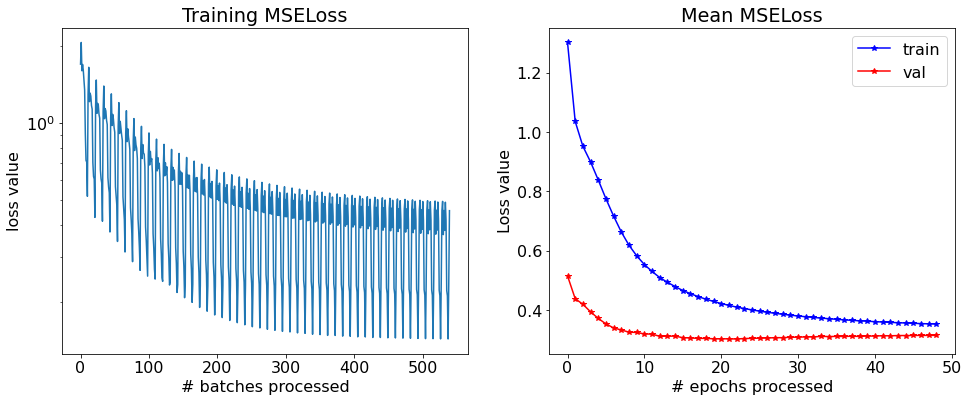

 27%|██▋       | 3/11 [00:00<00:02,  3.39it/s]

tensor(0.4931, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3653, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4545, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3798, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4897, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 9/11 [00:00<00:00,  5.93it/s]

tensor(0.4156, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2213, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2108, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1432, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2393, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 5/5 [00:00<00:00, 81.74it/s]

Updating learning rate to 8.52575903343082e-05
Train time 49.32s
Val loss


In [24]:
train(transform, device, criterion, opt, num_epochs, lr, train_loader, val_loader)

In [25]:
transform.eval();

In [26]:
def Predict_Y(loader, model, scaler):
  
    y_true = []
    y_pred = []
  
    for batch in loader:

        X,Y = batch[:2]
        
        X = X.to(device)
        Y = Y.to(device)
        y_true.append(scaler.inverse_transform(Y.cpu().detach().numpy()))
        y_pred.append(scaler.inverse_transform(model(X).cpu().detach().numpy()))
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    return y_true, y_pred

In [27]:
y_test_true,  y_test_Transformer = Predict_Y(test_loader, transform, scaler_y)

In [42]:
print(f'mse = {mean_squared_error(y_test_true[:, 0], y_test_Transformer[:, 0])}')

mse = 0.00306443078443408


In [43]:
y_test_Transformer.shape

(1162, 9)

In [40]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df0 = pd.Series(y_test_true[:, 0])  #dataframe with ground truth

df_pred = pd.DataFrame(y_test_Transformer) #dataframe with predicted data

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)

fig.add_trace(go.Scatter(x=df0.index, y=df0, mode='lines',name = 'true',line=dict(color='royalblue', dash='dot'),showlegend=True), row=1, col=1) #
fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[0], mode='lines', name='pred',line=dict(color='#EF553B')), row=1, col=1)

fig.update_layout(width=1200, height=1000, template='plotly_white',showlegend=True, legend=dict(x=0, y=1,bordercolor="Black",borderwidth=2))

fig.update_xaxes( row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text="WindSpeed", row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)


fig.show()

with open('/content/test_pred2.html', 'a') as f:

        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height = 1200, default_width = 900))
       
fig.write_html('/content/test_pred2.html')

##FFT Transformer

In [32]:
transform_fft = Transformer(dim_val, dim_attn, input_size, dec_seq_len,  
                    output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, fourier = True).to(device)

lr = 1e-3
criterion =  nn.MSELoss()
opt = torch.optim.Adam(transform_fft.parameters(), lr=lr,weight_decay=1e-3)
#opt = torch.optim.SGD(model.parameters(), lr=lr,weight_decay=1e-3,momentum=0.999)

num_epochs = 50

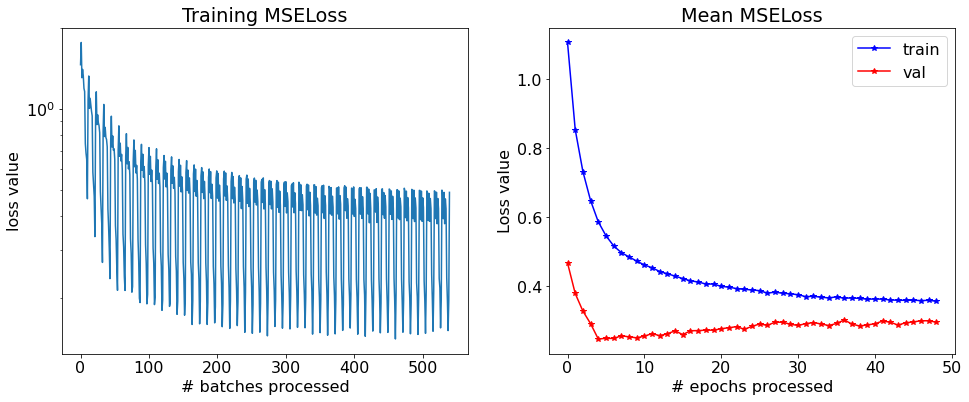

 36%|███▋      | 4/11 [00:00<00:02,  3.41it/s]

tensor(0.4930, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3941, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4919, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3825, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4624, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4276, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 5/5 [00:00<00:00, 96.96it/s]

tensor(0.2320, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1857, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1489, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1922, device='cuda:0', grad_fn=<MseLossBackward>)
Updating learning rate to 8.52575903343082e-05
Train time 43.70s
Val loss


In [33]:
train(transform_fft, device, criterion, opt, num_epochs, lr, train_loader, val_loader)

In [34]:
transform_fft.eval();

In [35]:
y_test_true,  y_test_Transformer_fft = Predict_Y(test_loader, transform_fft, scaler_y)

In [44]:
print(f'mse = {mean_squared_error(y_test_true[:, 0], y_test_Transformer_fft[:, 0])}')

mse = 0.005252881441265345


In [45]:
y_test_Transformer_fft.shape

(1162, 9)

In [41]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df0 = pd.Series(y_test_true[:, 0])  #dataframe with ground truth

df_pred = pd.DataFrame(y_test_Transformer_fft) #dataframe with predicted data

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)

fig.add_trace(go.Scatter(x=df0.index, y=df0, mode='lines',name = 'true',line=dict(color='royalblue', dash='dot'),showlegend=True), row=1, col=1) #
fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[0], mode='lines', name='pred',line=dict(color='#EF553B')), row=1, col=1)

fig.update_layout(width=1200, height=1000, template='plotly_white',showlegend=True, legend=dict(x=0, y=1,bordercolor="Black",borderwidth=2))

fig.update_xaxes( row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text="WindSpeed", row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)


fig.show()

with open('/content/test_pred2.html', 'a') as f:

        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height = 1200, default_width = 900))
       
fig.write_html('/content/test_pred2.html')